In [1]:
import numpy as np
import tensorflow as tf
import my_tf_tool as mt
import datetime
import pickle
import matplotlib.pyplot as plt

### Load the training and testing data

In [2]:
# you can download this dataset online at: 
# https://drive.google.com/file/d/134n4Te9M8cJEbeKxYID1C5I6dtjpsSUY/view?usp=sharing
filename = 'Neural_Nets.pkl'
with open(filename, 'rb') as f:
    d = pickle.load(f)
    train_data = d[0]
    train_label = d[1].astype(np.float32)
    test_data = d[2]
    test_label = d[3]
    print(test_data.shape)
    print(test_label.shape)
    print(train_data.shape)
    print(train_label.shape)

(5000, 784)
(5000, 10)
(50000, 784)
(50000, 10)


### Normalize the images and add a bias term to the original data

In [3]:
# normalization
train_data /= 255
test_data /= 255

hm_train_data, feature_dim = train_data.shape
hm_test_data, hm_class = test_label.shape

# add the bias term as the last column of the data
train_data = np.hstack((train_data, np.ones((hm_train_data, 1), dtype=np.float32)))
test_data = np.hstack((test_data, np.ones((hm_test_data, 1), dtype=np.float32)))
feature_dim += 1

### Setup hyperparameters for training the 2-layer Neural Nets

In [4]:
learning_rate = 0.01
learning_epoch = 25
lr_decay = 0.6
eval_interval = 100
batch_size = 50
reg_lambda = 0.000002

hm_nodes_hid1 = 100
hm_nodes_hid2 = 100

### Define the architecture of the model in tensorflow, and globle variables to store some intermediate results

In [5]:
x = tf.placeholder(np.float32, [None, feature_dim])
y = tf.placeholder(np.float32, [None, hm_class])

In [6]:
weight = {'w1': tf.Variable(tf.truncated_normal([hm_nodes_hid1, feature_dim], mean=0.1, stddev=0.01) / 10),
          'w2': tf.Variable(tf.truncated_normal([hm_nodes_hid2, hm_nodes_hid1 + 1], mean=0.1, stddev=0.01) / 10),
          'w3': tf.Variable(tf.truncated_normal([hm_class, hm_nodes_hid2 + 1], mean=0.1, stddev=0.01) / 10)}

losses = np.zeros((0, 1))
w1 = np.zeros([hm_nodes_hid1, feature_dim], dtype=np.float32)
w2 = np.zeros([hm_nodes_hid2, hm_nodes_hid1 + 1], dtype=np.float32)
w3 = np.zeros([hm_class, hm_nodes_hid2 + 1], dtype=np.float32)
training_acc = np.zeros((0, 1))
testing_acc = np.zeros((0, 1))
#prob = np.zeros([])

In [7]:
train_acc, loss = mt.compute_accuracy(train_data, train_label, weight, reg_lambda, hm_train_data)
grads = mt.forward_back_props(weight, x, y, reg_lambda, batch_size)
weight['w1'] = tf.assign_sub(weight['w1'], learning_rate * (grads['w1'] + weight['w1'] * reg_lambda))
weight['w2'] = tf.assign_sub(weight['w2'], learning_rate * (grads['w2'] + weight['w2'] * reg_lambda))
weight['w3'] = tf.assign_sub(weight['w3'], learning_rate * (grads['w3'] + weight['w3'] * reg_lambda))
test_acc, lll = mt.compute_accuracy(test_data, test_label, weight, reg_lambda, hm_test_data)

### Start training the model

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for s in np.arange(learning_epoch):
        start = datetime.datetime.now()
        re_order = np.random.permutation(hm_train_data)
        for i in np.arange(int(hm_train_data / batch_size)):
            batch_x = train_data[re_order[i * batch_size:(i + 1) * batch_size], :]
            batch_y = train_label[re_order[i * batch_size:(i + 1) * batch_size], :]

            w1, w2, w3, _ = sess.run([weight['w1'], weight['w2'], weight['w3'], grads],
                                     feed_dict={x: batch_x, y: batch_y})

            if i % eval_interval == 0:
                tr_acc, l = sess.run([train_acc, loss])
                te_acc, _ = sess.run([test_acc, lll], feed_dict={x:test_data, y: test_label})
                losses = np.vstack((losses, l))
                training_acc = np.vstack((training_acc, tr_acc))
                testing_acc = np.vstack((testing_acc, te_acc))
                print('Epoch', s, 'eval at', i, 'loss', l, 'training_acc', tr_acc, 'testing_acc', te_acc)

        learning_rate *= lr_decay / (s + 1)
        dur = datetime.datetime.now() - start
        print('runtime for', s,  'epoch is ', dur)

Epoch 0 eval at 0 loss 22723.6 training_acc 0.10202 testing_acc 0.103
Epoch 0 eval at 100 loss 22356.1 training_acc 0.12008 testing_acc 0.1108
Epoch 0 eval at 200 loss 22144.5 training_acc 0.19526 testing_acc 0.192
Epoch 0 eval at 300 loss 21257.2 training_acc 0.2113 testing_acc 0.2048
Epoch 0 eval at 400 loss 20384.9 training_acc 0.23368 testing_acc 0.231
Epoch 0 eval at 500 loss 19624.6 training_acc 0.27896 testing_acc 0.2686
Epoch 0 eval at 600 loss 19144.4 training_acc 0.27342 testing_acc 0.2652
Epoch 0 eval at 700 loss 18655.1 training_acc 0.29574 testing_acc 0.287
Epoch 0 eval at 800 loss 18469.1 training_acc 0.30282 testing_acc 0.291
Epoch 0 eval at 900 loss 18082.7 training_acc 0.32046 testing_acc 0.3078
runtime for 0 epoch is  0:00:22.284250
Epoch 1 eval at 0 loss 17603.1 training_acc 0.38816 testing_acc 0.366
Epoch 1 eval at 100 loss 17156.0 training_acc 0.3905 testing_acc 0.363
Epoch 1 eval at 200 loss 16081.0 training_acc 0.44248 testing_acc 0.4374
Epoch 1 eval at 300 loss 

Epoch 10 eval at 800 loss 819.133 training_acc 0.9799 testing_acc 0.9646
Epoch 10 eval at 900 loss 810.467 training_acc 0.9801 testing_acc 0.9646
runtime for 10 epoch is  0:00:16.728067
Epoch 11 eval at 0 loss 751.438 training_acc 0.98206 testing_acc 0.967
Epoch 11 eval at 100 loss 832.194 training_acc 0.97964 testing_acc 0.9648
Epoch 11 eval at 200 loss 718.82 training_acc 0.98272 testing_acc 0.9656
Epoch 11 eval at 300 loss 740.994 training_acc 0.98236 testing_acc 0.9634
Epoch 11 eval at 400 loss 787.524 training_acc 0.98054 testing_acc 0.9636
Epoch 11 eval at 500 loss 697.926 training_acc 0.98324 testing_acc 0.9656
Epoch 11 eval at 600 loss 845.172 training_acc 0.97926 testing_acc 0.962
Epoch 11 eval at 700 loss 780.298 training_acc 0.98098 testing_acc 0.963
Epoch 11 eval at 800 loss 953.42 training_acc 0.9761 testing_acc 0.9636
Epoch 11 eval at 900 loss 677.56 training_acc 0.98388 testing_acc 0.9672
runtime for 11 epoch is  0:00:16.317235
Epoch 12 eval at 0 loss 709.318 training_ac

Epoch 21 eval at 500 loss 319.829 training_acc 0.99296 testing_acc 0.9718
Epoch 21 eval at 600 loss 325.542 training_acc 0.99268 testing_acc 0.9722
Epoch 21 eval at 700 loss 507.268 training_acc 0.98814 testing_acc 0.9688
Epoch 21 eval at 800 loss 343.421 training_acc 0.99232 testing_acc 0.9702
Epoch 21 eval at 900 loss 313.695 training_acc 0.99308 testing_acc 0.9718
runtime for 21 epoch is  0:00:14.002517
Epoch 22 eval at 0 loss 368.672 training_acc 0.99148 testing_acc 0.9704
Epoch 22 eval at 100 loss 345.144 training_acc 0.9922 testing_acc 0.9702
Epoch 22 eval at 200 loss 318.93 training_acc 0.99292 testing_acc 0.971
Epoch 22 eval at 300 loss 314.512 training_acc 0.99292 testing_acc 0.9702
Epoch 22 eval at 400 loss 284.951 training_acc 0.99376 testing_acc 0.9726
Epoch 22 eval at 500 loss 305.287 training_acc 0.99346 testing_acc 0.9722
Epoch 22 eval at 600 loss 298.275 training_acc 0.99354 testing_acc 0.9738
Epoch 22 eval at 700 loss 321.23 training_acc 0.9931 testing_acc 0.9706
Epoch

### Plot the learning curves while training

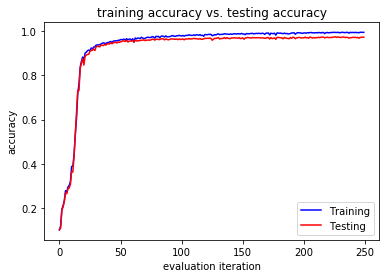

In [9]:
x1, _ = training_acc.shape
x2, _ = testing_acc.shape
tr = plt.plot(np.arange(x1), training_acc, 'b-', label='Training')
te = plt.plot(np.arange(x2), testing_acc, 'r-', label='Testing')
plt.title('training accuracy vs. testing accuracy')
plt.legend()
plt.xlabel('evaluation iteration')
plt.ylabel('accuracy')
plt.show()

#### The training accuracy continues to improve while the testing performance reaches its bottleneck, the training loss keeps dropping down

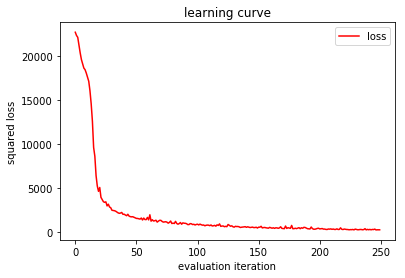

In [10]:
x3, _ = losses.shape
l = plt.plot(np.arange(x3), losses, 'r-', label='loss')
plt.title('learning curve')
plt.legend()
plt.xlabel('evaluation iteration')
plt.ylabel('squared loss')
plt.show()

### Save the model weights in the desired format

In [11]:
import pickle
Theta = []
Theta.append(np.transpose(w1[:, 0:-1]))
Theta.append(w1[:, -1][:, None])
Theta.append(np.transpose(w2[:, 0:-1]))
Theta.append(w2[:, -1][:, None])
Theta.append(np.transpose(w3[:, 0:-1]))
Theta.append(w3[:, -1][:, None])
filehandler = open('nn_parameters.txt', 'wb')
pickle.dump(Theta, filehandler)
filehandler.close()